In [1]:
from datetime import datetime
from typing import List

import uuid

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LinearRegression

from dowhy import gcm
import networkx as nx

from catboost import Pool, CatBoostRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\aleks\anaconda3\envs\causal_dowhy_catboost_sklearan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.version

'3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]'

# Using `dowhy` GCM API w/ Categorical & Mixed Data

## DGP

In [3]:
# Data generatring process
class DGP:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_t0 = stats.gamma(4, 2)
        self.u_t1 = stats.norm(0, 1)
        self.u_y0 = stats.truncnorm(0, np.infty, scale=5)
        self.u_y1 = stats.norm(0, 1)

    def sample(self, sample_size=20, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)

        # Sample noises
        u_t0 = self.u_t0.rvs(sample_size)
        u_t1 = self.u_t1.rvs(sample_size)
        u_y0 = self.u_y0.rvs(sample_size)
        u_y1 = self.u_y1.rvs(sample_size)

        Z = np.random.choice(a=[0, 1, 2], p=[.35, .2, .45], size=sample_size)

        if treatment_value is not None:
            T = np.array(([treatment_value]*sample_size))
        else:
            T = np.where(Z == 0, 1.5 + np.log(u_t0), 0) + \
                np.where(Z == 1, 2.7 * np.sin(u_t0), 0) + \
                np.where(Z == 2, 3 * np.cos(u_t0) - np.sqrt(u_t0), 0) + \
                u_t1

        Y = 3 * T * -np.where(Z != 0, 1.7 * np.sqrt(u_y0), -3) + \
            np.where(Z == 0, 0.7 * np.sqrt(u_y0), 0) + \
            np.where(Z == 1, 2.7 * np.sqrt(u_y0), 0) + \
            np.where(Z == 2, u_y0, 0) + \
            u_y1

        return T, Z, Y

    def intervene(self, treatment_value, sample_size=20):
        return self.sample(
            treatment_value=treatment_value,
            sample_size=sample_size
        )

In [4]:
dgp = DGP()

N_INTERVENTIONAL_SAMPLES = 5

int_sample = {'T': [], 'Y': []}

for t in np.arange(-7.5, 6, .1):
    samples = dgp.intervene(treatment_value=t, sample_size=N_INTERVENTIONAL_SAMPLES)
    int_sample['T'] += [t]*N_INTERVENTIONAL_SAMPLES
    int_sample['Y'] += samples[2].tolist()

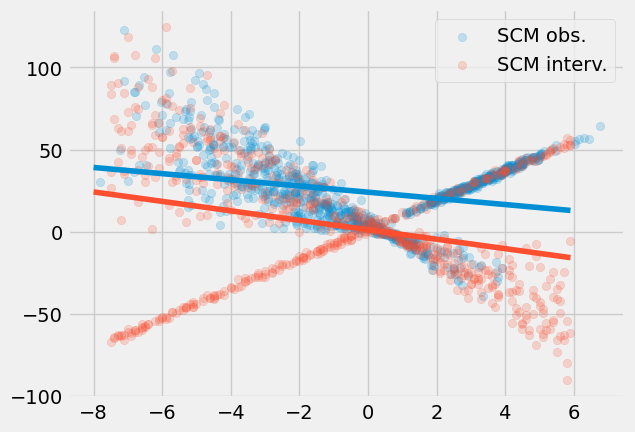

In [5]:
# Visualize the data
sample_obs = dgp.sample(1000)
plt.scatter(sample_obs[0], sample_obs[2], alpha=.2, label='SCM obs.')
plt.scatter(int_sample['T'], int_sample['Y'], alpha=.2, label='SCM interv.')

# Add regression lines
lr_obs = LinearRegression()
lr_int = LinearRegression()
lr_obs.fit(X=sample_obs[0].reshape(-1, 1), y=sample_obs[2])
lr_int.fit(X=np.array(int_sample['T']).reshape(-1, 1), y=int_sample['Y'])
lr_obs_pred = lr_obs.predict(np.arange(-8, 6, .1).reshape(-1, 1))
lr_int_pred = lr_int.predict(np.arange(-8, 6, .1).reshape(-1, 1))

plt.plot(np.arange(-8, 6, .1), lr_obs_pred)
plt.plot(np.arange(-8, 6, .1), lr_int_pred)

plt.legend()

## Build the model

In [6]:
# Create a model
causal_model = gcm.ProbabilisticCausalModel(
    nx.DiGraph(
        [
            ('T', 'Y'),
            ('Z', 'T'),
            ('Z', 'Y')
            ]
        )
    )

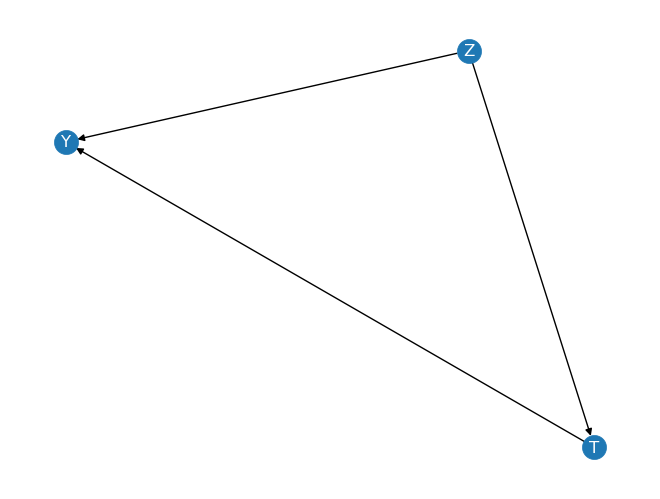

In [7]:
nx.draw(causal_model.graph, with_labels=True, font_color='white')

### Define classes

In [8]:
# Define categorical distribution stochastic model
class CategoricalStochasticModel(gcm.causal_mechanisms.StochasticModel):

    def fit(self, X: np.ndarray):
        self.unique_values = np.unique(X)
        self.probas = []
        for v in self.unique_values:
            self.probas.append((X == v).sum() / X.shape[0])

    def draw_samples(self, num_samples: int) -> np.ndarray:
        return np.random.choice(a=self.unique_values, p=self.probas, size=num_samples)

    def clone(self):
        return CategoricalStochasticModel()

In [28]:
# Define a CatBoost-based prediction model that allows for native support of categorical variables
class CatBoostRegressorPredictionModel(gcm.ml.prediction_model.PredictionModel):
    
    def __init__(self, categorical_variable_indices: List[int]=None, catboost_params: dict={}):
        self.categorical_variable_indices = categorical_variable_indices # has to be ints
        self.catboost_params = catboost_params
        self.model = CatBoostRegressor(**self.catboost_params)
        
    def fit(self, X: np.ndarray, Y: np.ndarray) -> None:
        
        # Convert back to pd df to deal with CatBoost data requirements
        X = pd.DataFrame(X)
        
        # Cast categorical vars to int
        if self.categorical_variable_indices:
            X[self.categorical_variable_indices] = X[self.categorical_variable_indices].astype(int)
        
        # Fit the model
        self.model.fit(X=X, y=Y, cat_features=self.categorical_variable_indices)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        
        # Convert back to pd df to deal with CatBoost data requirements
        X = pd.DataFrame(X)
        
        # Cast categorical vars to int
        if self.categorical_variable_indices:
            X[self.categorical_variable_indices] = X[self.categorical_variable_indices].astype(int)
        
        # Return predictions
        return self.model.predict(X)
    
    def clone(self):
        return CatBoostRegressorPredictionModel(self.categorical_variable_indices, self.catboost_params)

### Set mechanisms

In [38]:
# Define hyperparams
LR = .06
N_ESTIMATORS = 2500
MAX_DEPTH = 16

# Confounder mechanism
causal_model.set_causal_mechanism('Z', CategoricalStochasticModel())

# Treatment mechanism
causal_model.set_causal_mechanism(
    'T',
    gcm.AdditiveNoiseModel(
        prediction_model=CatBoostRegressorPredictionModel(
            categorical_variable_indices=[0],
            catboost_params={
                'n_estimators': N_ESTIMATORS,
                'learning_rate': LR,
                'max_depth': MAX_DEPTH
            }
        ),
        noise_model=gcm.ScipyDistribution(stats.norm)
    )
)

# Outcome mechanism
causal_model.set_causal_mechanism(
    'Y',
    gcm.AdditiveNoiseModel(
        prediction_model=CatBoostRegressorPredictionModel(
            categorical_variable_indices=[1],
            catboost_params={
                'n_estimators': N_ESTIMATORS,
                'learning_rate': LR,
                'max_depth': MAX_DEPTH
            }
        ),
        noise_model=gcm.ScipyDistribution(stats.norm)
    )
)

### Fit the model

In [32]:
# Wrap the data in a df
data = pd.DataFrame(sample_obs).T
data.columns = ['T', 'Z', 'Y']
data['Z'] = data['Z'].astype(int)

In [33]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node T:   0%|                                                        | 0/3 [00:00<?, ?it/s]

0:	learn: 2.9999267	total: 12.7ms	remaining: 31.6s
1:	learn: 2.9471711	total: 95.3ms	remaining: 1m 59s
2:	learn: 2.8968739	total: 128ms	remaining: 1m 46s
3:	learn: 2.8481655	total: 202ms	remaining: 2m 6s
4:	learn: 2.8018497	total: 256ms	remaining: 2m 7s
5:	learn: 2.7577524	total: 360ms	remaining: 2m 29s
6:	learn: 2.7151732	total: 441ms	remaining: 2m 37s
7:	learn: 2.6745259	total: 522ms	remaining: 2m 42s
8:	learn: 2.6356376	total: 619ms	remaining: 2m 51s
9:	learn: 2.5983870	total: 659ms	remaining: 2m 44s
10:	learn: 2.5628457	total: 720ms	remaining: 2m 42s
11:	learn: 2.5292520	total: 812ms	remaining: 2m 48s
12:	learn: 2.4973923	total: 869ms	remaining: 2m 46s
13:	learn: 2.4678861	total: 900ms	remaining: 2m 39s
14:	learn: 2.4391886	total: 950ms	remaining: 2m 37s
15:	learn: 2.4111637	total: 1.02s	remaining: 2m 38s
16:	learn: 2.3843483	total: 1.07s	remaining: 2m 36s
17:	learn: 2.3600580	total: 1.1s	remaining: 2m 31s
18:	learn: 2.3359706	total: 1.16s	remaining: 2m 31s
19:	learn: 2.3130723	tot

160:	learn: 1.8777503	total: 9.02s	remaining: 2m 11s
161:	learn: 1.8777382	total: 9.07s	remaining: 2m 10s
162:	learn: 1.8775466	total: 9.14s	remaining: 2m 11s
163:	learn: 1.8775392	total: 9.16s	remaining: 2m 10s
164:	learn: 1.8774748	total: 9.21s	remaining: 2m 10s
165:	learn: 1.8773566	total: 9.26s	remaining: 2m 10s
166:	learn: 1.8772538	total: 9.31s	remaining: 2m 10s
167:	learn: 1.8772001	total: 9.38s	remaining: 2m 10s
168:	learn: 1.8771173	total: 9.45s	remaining: 2m 10s
169:	learn: 1.8770688	total: 9.51s	remaining: 2m 10s
170:	learn: 1.8769369	total: 9.61s	remaining: 2m 10s
171:	learn: 1.8768097	total: 9.68s	remaining: 2m 11s
172:	learn: 1.8768022	total: 9.71s	remaining: 2m 10s
173:	learn: 1.8768022	total: 9.73s	remaining: 2m 10s
174:	learn: 1.8765043	total: 9.8s	remaining: 2m 10s
175:	learn: 1.8764572	total: 9.83s	remaining: 2m 9s
176:	learn: 1.8763530	total: 9.91s	remaining: 2m 10s
177:	learn: 1.8762783	total: 9.97s	remaining: 2m 10s
178:	learn: 1.8762775	total: 10s	remaining: 2m 9

317:	learn: 1.8637659	total: 19.2s	remaining: 2m 11s
318:	learn: 1.8635889	total: 19.3s	remaining: 2m 11s
319:	learn: 1.8635753	total: 19.4s	remaining: 2m 11s
320:	learn: 1.8634610	total: 19.5s	remaining: 2m 12s
321:	learn: 1.8634610	total: 19.5s	remaining: 2m 11s
322:	learn: 1.8633268	total: 19.6s	remaining: 2m 12s
323:	learn: 1.8631923	total: 19.7s	remaining: 2m 12s
324:	learn: 1.8630915	total: 19.8s	remaining: 2m 12s
325:	learn: 1.8630219	total: 19.9s	remaining: 2m 12s
326:	learn: 1.8628427	total: 20s	remaining: 2m 12s
327:	learn: 1.8628426	total: 20s	remaining: 2m 12s
328:	learn: 1.8628332	total: 20s	remaining: 2m 12s
329:	learn: 1.8627645	total: 20.1s	remaining: 2m 12s
330:	learn: 1.8626585	total: 20.2s	remaining: 2m 12s
331:	learn: 1.8625581	total: 20.3s	remaining: 2m 12s
332:	learn: 1.8623771	total: 20.4s	remaining: 2m 12s
333:	learn: 1.8622497	total: 20.5s	remaining: 2m 13s
334:	learn: 1.8622043	total: 20.6s	remaining: 2m 12s
335:	learn: 1.8621027	total: 20.7s	remaining: 2m 13s

474:	learn: 1.8520964	total: 32.1s	remaining: 2m 16s
475:	learn: 1.8519789	total: 32.2s	remaining: 2m 16s
476:	learn: 1.8519789	total: 32.2s	remaining: 2m 16s
477:	learn: 1.8518508	total: 32.3s	remaining: 2m 16s
478:	learn: 1.8518508	total: 32.3s	remaining: 2m 16s
479:	learn: 1.8518268	total: 32.4s	remaining: 2m 16s
480:	learn: 1.8518073	total: 32.4s	remaining: 2m 16s
481:	learn: 1.8517735	total: 32.5s	remaining: 2m 16s
482:	learn: 1.8517672	total: 32.6s	remaining: 2m 16s
483:	learn: 1.8517497	total: 32.7s	remaining: 2m 16s
484:	learn: 1.8517269	total: 32.8s	remaining: 2m 16s
485:	learn: 1.8517006	total: 32.9s	remaining: 2m 16s
486:	learn: 1.8515864	total: 33s	remaining: 2m 16s
487:	learn: 1.8515443	total: 33.1s	remaining: 2m 16s
488:	learn: 1.8515266	total: 33.2s	remaining: 2m 16s
489:	learn: 1.8514482	total: 33.3s	remaining: 2m 16s
490:	learn: 1.8513192	total: 33.4s	remaining: 2m 16s
491:	learn: 1.8512450	total: 33.5s	remaining: 2m 16s
492:	learn: 1.8511141	total: 33.6s	remaining: 2m

631:	learn: 1.8473373	total: 45.7s	remaining: 2m 15s
632:	learn: 1.8472968	total: 45.8s	remaining: 2m 15s
633:	learn: 1.8472849	total: 46s	remaining: 2m 15s
634:	learn: 1.8472699	total: 46.1s	remaining: 2m 15s
635:	learn: 1.8472586	total: 46.2s	remaining: 2m 15s
636:	learn: 1.8472481	total: 46.3s	remaining: 2m 15s
637:	learn: 1.8472386	total: 46.4s	remaining: 2m 15s
638:	learn: 1.8472094	total: 46.5s	remaining: 2m 15s
639:	learn: 1.8472094	total: 46.5s	remaining: 2m 15s
640:	learn: 1.8472089	total: 46.6s	remaining: 2m 15s
641:	learn: 1.8471986	total: 46.7s	remaining: 2m 15s
642:	learn: 1.8471986	total: 46.7s	remaining: 2m 14s
643:	learn: 1.8471718	total: 46.8s	remaining: 2m 14s
644:	learn: 1.8471450	total: 46.9s	remaining: 2m 15s
645:	learn: 1.8471205	total: 47s	remaining: 2m 15s
646:	learn: 1.8470925	total: 47.2s	remaining: 2m 15s
647:	learn: 1.8470433	total: 47.3s	remaining: 2m 15s
648:	learn: 1.8469866	total: 47.4s	remaining: 2m 15s
649:	learn: 1.8469763	total: 47.5s	remaining: 2m 1

788:	learn: 1.8451426	total: 1m	remaining: 2m 10s
789:	learn: 1.8451426	total: 1m	remaining: 2m 10s
790:	learn: 1.8451425	total: 1m	remaining: 2m 10s
791:	learn: 1.8451281	total: 1m	remaining: 2m 10s
792:	learn: 1.8451245	total: 1m	remaining: 2m 10s
793:	learn: 1.8451245	total: 1m	remaining: 2m 10s
794:	learn: 1.8451244	total: 1m	remaining: 2m 10s
795:	learn: 1.8451138	total: 1m	remaining: 2m 10s
796:	learn: 1.8451138	total: 1m	remaining: 2m 10s
797:	learn: 1.8451132	total: 1m	remaining: 2m 10s
798:	learn: 1.8451076	total: 1m 1s	remaining: 2m 10s
799:	learn: 1.8450887	total: 1m 1s	remaining: 2m 10s
800:	learn: 1.8450883	total: 1m 1s	remaining: 2m 10s
801:	learn: 1.8450633	total: 1m 1s	remaining: 2m 10s
802:	learn: 1.8450361	total: 1m 1s	remaining: 2m 9s
803:	learn: 1.8450287	total: 1m 1s	remaining: 2m 9s
804:	learn: 1.8450268	total: 1m 1s	remaining: 2m 9s
805:	learn: 1.8450263	total: 1m 1s	remaining: 2m 9s
806:	learn: 1.8450222	total: 1m 1s	remaining: 2m 9s
807:	learn: 1.8449975	total:

945:	learn: 1.8441953	total: 1m 15s	remaining: 2m 3s
946:	learn: 1.8441938	total: 1m 15s	remaining: 2m 3s
947:	learn: 1.8441920	total: 1m 15s	remaining: 2m 3s
948:	learn: 1.8441780	total: 1m 15s	remaining: 2m 3s
949:	learn: 1.8441753	total: 1m 15s	remaining: 2m 3s
950:	learn: 1.8441715	total: 1m 15s	remaining: 2m 3s
951:	learn: 1.8441715	total: 1m 15s	remaining: 2m 2s
952:	learn: 1.8441694	total: 1m 15s	remaining: 2m 2s
953:	learn: 1.8441599	total: 1m 15s	remaining: 2m 2s
954:	learn: 1.8441596	total: 1m 15s	remaining: 2m 2s
955:	learn: 1.8441596	total: 1m 15s	remaining: 2m 2s
956:	learn: 1.8441515	total: 1m 16s	remaining: 2m 2s
957:	learn: 1.8441500	total: 1m 16s	remaining: 2m 2s
958:	learn: 1.8441485	total: 1m 16s	remaining: 2m 2s
959:	learn: 1.8441485	total: 1m 16s	remaining: 2m 2s
960:	learn: 1.8441470	total: 1m 16s	remaining: 2m 2s
961:	learn: 1.8441467	total: 1m 16s	remaining: 2m 2s
962:	learn: 1.8441456	total: 1m 16s	remaining: 2m 2s
963:	learn: 1.8441454	total: 1m 16s	remaining:

1099:	learn: 1.8436647	total: 1m 30s	remaining: 1m 55s
1100:	learn: 1.8436643	total: 1m 30s	remaining: 1m 55s
1101:	learn: 1.8436583	total: 1m 30s	remaining: 1m 55s
1102:	learn: 1.8436565	total: 1m 30s	remaining: 1m 55s
1103:	learn: 1.8436558	total: 1m 30s	remaining: 1m 55s
1104:	learn: 1.8436552	total: 1m 31s	remaining: 1m 54s
1105:	learn: 1.8436544	total: 1m 31s	remaining: 1m 54s
1106:	learn: 1.8436491	total: 1m 31s	remaining: 1m 54s
1107:	learn: 1.8436442	total: 1m 31s	remaining: 1m 54s
1108:	learn: 1.8436415	total: 1m 31s	remaining: 1m 54s
1109:	learn: 1.8436401	total: 1m 31s	remaining: 1m 54s
1110:	learn: 1.8436396	total: 1m 31s	remaining: 1m 54s
1111:	learn: 1.8436352	total: 1m 31s	remaining: 1m 54s
1112:	learn: 1.8436318	total: 1m 31s	remaining: 1m 54s
1113:	learn: 1.8436309	total: 1m 32s	remaining: 1m 54s
1114:	learn: 1.8436257	total: 1m 32s	remaining: 1m 54s
1115:	learn: 1.8436250	total: 1m 32s	remaining: 1m 54s
1116:	learn: 1.8436224	total: 1m 32s	remaining: 1m 54s
1117:	lear

1248:	learn: 1.8434390	total: 1m 46s	remaining: 1m 46s
1249:	learn: 1.8434389	total: 1m 46s	remaining: 1m 46s
1250:	learn: 1.8434362	total: 1m 46s	remaining: 1m 46s
1251:	learn: 1.8434359	total: 1m 46s	remaining: 1m 46s
1252:	learn: 1.8434342	total: 1m 46s	remaining: 1m 46s
1253:	learn: 1.8434323	total: 1m 46s	remaining: 1m 46s
1254:	learn: 1.8434310	total: 1m 46s	remaining: 1m 46s
1255:	learn: 1.8434309	total: 1m 46s	remaining: 1m 45s
1256:	learn: 1.8434304	total: 1m 47s	remaining: 1m 45s
1257:	learn: 1.8434290	total: 1m 47s	remaining: 1m 45s
1258:	learn: 1.8434261	total: 1m 47s	remaining: 1m 45s
1259:	learn: 1.8434245	total: 1m 47s	remaining: 1m 45s
1260:	learn: 1.8434231	total: 1m 47s	remaining: 1m 45s
1261:	learn: 1.8434225	total: 1m 47s	remaining: 1m 45s
1262:	learn: 1.8434222	total: 1m 47s	remaining: 1m 45s
1263:	learn: 1.8434219	total: 1m 47s	remaining: 1m 45s
1264:	learn: 1.8434216	total: 1m 47s	remaining: 1m 45s
1265:	learn: 1.8434208	total: 1m 48s	remaining: 1m 45s
1266:	lear

1400:	learn: 1.8433226	total: 2m 2s	remaining: 1m 36s
1401:	learn: 1.8433222	total: 2m 2s	remaining: 1m 35s
1402:	learn: 1.8433213	total: 2m 2s	remaining: 1m 35s
1403:	learn: 1.8433212	total: 2m 2s	remaining: 1m 35s
1404:	learn: 1.8433212	total: 2m 2s	remaining: 1m 35s
1405:	learn: 1.8433212	total: 2m 2s	remaining: 1m 35s
1406:	learn: 1.8433204	total: 2m 2s	remaining: 1m 35s
1407:	learn: 1.8433203	total: 2m 3s	remaining: 1m 35s
1408:	learn: 1.8433193	total: 2m 3s	remaining: 1m 35s
1409:	learn: 1.8433192	total: 2m 3s	remaining: 1m 35s
1410:	learn: 1.8433175	total: 2m 3s	remaining: 1m 35s
1411:	learn: 1.8433167	total: 2m 3s	remaining: 1m 35s
1412:	learn: 1.8433164	total: 2m 3s	remaining: 1m 35s
1413:	learn: 1.8433162	total: 2m 3s	remaining: 1m 35s
1414:	learn: 1.8433161	total: 2m 3s	remaining: 1m 34s
1415:	learn: 1.8433161	total: 2m 3s	remaining: 1m 34s
1416:	learn: 1.8433160	total: 2m 4s	remaining: 1m 34s
1417:	learn: 1.8433157	total: 2m 4s	remaining: 1m 34s
1418:	learn: 1.8433148	total

1551:	learn: 1.8432627	total: 2m 18s	remaining: 1m 24s
1552:	learn: 1.8432623	total: 2m 18s	remaining: 1m 24s
1553:	learn: 1.8432615	total: 2m 18s	remaining: 1m 24s
1554:	learn: 1.8432612	total: 2m 18s	remaining: 1m 24s
1555:	learn: 1.8432607	total: 2m 18s	remaining: 1m 24s
1556:	learn: 1.8432605	total: 2m 18s	remaining: 1m 24s
1557:	learn: 1.8432603	total: 2m 18s	remaining: 1m 24s
1558:	learn: 1.8432603	total: 2m 19s	remaining: 1m 23s
1559:	learn: 1.8432601	total: 2m 19s	remaining: 1m 23s
1560:	learn: 1.8432601	total: 2m 19s	remaining: 1m 23s
1561:	learn: 1.8432596	total: 2m 19s	remaining: 1m 23s
1562:	learn: 1.8432595	total: 2m 19s	remaining: 1m 23s
1563:	learn: 1.8432595	total: 2m 19s	remaining: 1m 23s
1564:	learn: 1.8432589	total: 2m 19s	remaining: 1m 23s
1565:	learn: 1.8432589	total: 2m 19s	remaining: 1m 23s
1566:	learn: 1.8432586	total: 2m 19s	remaining: 1m 23s
1567:	learn: 1.8432585	total: 2m 20s	remaining: 1m 23s
1568:	learn: 1.8432585	total: 2m 20s	remaining: 1m 23s
1569:	lear

1700:	learn: 1.8432329	total: 2m 34s	remaining: 1m 12s
1701:	learn: 1.8432327	total: 2m 34s	remaining: 1m 12s
1702:	learn: 1.8432325	total: 2m 34s	remaining: 1m 12s
1703:	learn: 1.8432325	total: 2m 34s	remaining: 1m 12s
1704:	learn: 1.8432322	total: 2m 34s	remaining: 1m 12s
1705:	learn: 1.8432316	total: 2m 34s	remaining: 1m 11s
1706:	learn: 1.8432315	total: 2m 34s	remaining: 1m 11s
1707:	learn: 1.8432315	total: 2m 34s	remaining: 1m 11s
1708:	learn: 1.8432315	total: 2m 34s	remaining: 1m 11s
1709:	learn: 1.8432313	total: 2m 34s	remaining: 1m 11s
1710:	learn: 1.8432313	total: 2m 35s	remaining: 1m 11s
1711:	learn: 1.8432311	total: 2m 35s	remaining: 1m 11s
1712:	learn: 1.8432311	total: 2m 35s	remaining: 1m 11s
1713:	learn: 1.8432310	total: 2m 35s	remaining: 1m 11s
1714:	learn: 1.8432310	total: 2m 35s	remaining: 1m 11s
1715:	learn: 1.8432309	total: 2m 35s	remaining: 1m 11s
1716:	learn: 1.8432309	total: 2m 35s	remaining: 1m 11s
1717:	learn: 1.8432309	total: 2m 35s	remaining: 1m 10s
1718:	lear

1854:	learn: 1.8432154	total: 2m 50s	remaining: 59.2s
1855:	learn: 1.8432152	total: 2m 50s	remaining: 59.1s
1856:	learn: 1.8432152	total: 2m 50s	remaining: 59s
1857:	learn: 1.8432152	total: 2m 50s	remaining: 58.9s
1858:	learn: 1.8432149	total: 2m 50s	remaining: 58.9s
1859:	learn: 1.8432148	total: 2m 50s	remaining: 58.8s
1860:	learn: 1.8432147	total: 2m 50s	remaining: 58.7s
1861:	learn: 1.8432147	total: 2m 50s	remaining: 58.6s
1862:	learn: 1.8432147	total: 2m 51s	remaining: 58.5s
1863:	learn: 1.8432145	total: 2m 51s	remaining: 58.4s
1864:	learn: 1.8432145	total: 2m 51s	remaining: 58.3s
1865:	learn: 1.8432144	total: 2m 51s	remaining: 58.2s
1866:	learn: 1.8432141	total: 2m 51s	remaining: 58.2s
1867:	learn: 1.8432141	total: 2m 51s	remaining: 58.1s
1868:	learn: 1.8432141	total: 2m 51s	remaining: 58s
1869:	learn: 1.8432140	total: 2m 51s	remaining: 57.9s
1870:	learn: 1.8432140	total: 2m 51s	remaining: 57.8s
1871:	learn: 1.8432139	total: 2m 52s	remaining: 57.7s
1872:	learn: 1.8432139	total: 2m

2010:	learn: 1.8432075	total: 3m 7s	remaining: 45.6s
2011:	learn: 1.8432075	total: 3m 7s	remaining: 45.5s
2012:	learn: 1.8432073	total: 3m 7s	remaining: 45.4s
2013:	learn: 1.8432073	total: 3m 7s	remaining: 45.3s
2014:	learn: 1.8432072	total: 3m 7s	remaining: 45.2s
2015:	learn: 1.8432072	total: 3m 7s	remaining: 45.1s
2016:	learn: 1.8432072	total: 3m 8s	remaining: 45s
2017:	learn: 1.8432072	total: 3m 8s	remaining: 45s
2018:	learn: 1.8432072	total: 3m 8s	remaining: 44.9s
2019:	learn: 1.8432071	total: 3m 8s	remaining: 44.8s
2020:	learn: 1.8432070	total: 3m 8s	remaining: 44.7s
2021:	learn: 1.8432070	total: 3m 8s	remaining: 44.6s
2022:	learn: 1.8432070	total: 3m 8s	remaining: 44.5s
2023:	learn: 1.8432070	total: 3m 8s	remaining: 44.4s
2024:	learn: 1.8432070	total: 3m 8s	remaining: 44.3s
2025:	learn: 1.8432069	total: 3m 9s	remaining: 44.2s
2026:	learn: 1.8432069	total: 3m 9s	remaining: 44.1s
2027:	learn: 1.8432068	total: 3m 9s	remaining: 44s
2028:	learn: 1.8432065	total: 3m 9s	remaining: 44s
2

2164:	learn: 1.8432001	total: 3m 24s	remaining: 31.7s
2165:	learn: 1.8431999	total: 3m 24s	remaining: 31.6s
2166:	learn: 1.8431999	total: 3m 24s	remaining: 31.5s
2167:	learn: 1.8431999	total: 3m 25s	remaining: 31.4s
2168:	learn: 1.8431999	total: 3m 25s	remaining: 31.3s
2169:	learn: 1.8431999	total: 3m 25s	remaining: 31.2s
2170:	learn: 1.8431999	total: 3m 25s	remaining: 31.1s
2171:	learn: 1.8431997	total: 3m 25s	remaining: 31.1s
2172:	learn: 1.8431997	total: 3m 25s	remaining: 31s
2173:	learn: 1.8431997	total: 3m 25s	remaining: 30.9s
2174:	learn: 1.8431997	total: 3m 26s	remaining: 30.8s
2175:	learn: 1.8431996	total: 3m 26s	remaining: 30.7s
2176:	learn: 1.8431996	total: 3m 26s	remaining: 30.6s
2177:	learn: 1.8431996	total: 3m 26s	remaining: 30.5s
2178:	learn: 1.8431996	total: 3m 26s	remaining: 30.4s
2179:	learn: 1.8431996	total: 3m 26s	remaining: 30.3s
2180:	learn: 1.8431996	total: 3m 26s	remaining: 30.2s
2181:	learn: 1.8431996	total: 3m 26s	remaining: 30.1s
2182:	learn: 1.8431994	total: 

2317:	learn: 1.8431957	total: 3m 45s	remaining: 17.7s
2318:	learn: 1.8431956	total: 3m 45s	remaining: 17.6s
2319:	learn: 1.8431956	total: 3m 45s	remaining: 17.5s
2320:	learn: 1.8431956	total: 3m 45s	remaining: 17.4s
2321:	learn: 1.8431956	total: 3m 45s	remaining: 17.3s
2322:	learn: 1.8431954	total: 3m 45s	remaining: 17.2s
2323:	learn: 1.8431954	total: 3m 45s	remaining: 17.1s
2324:	learn: 1.8431954	total: 3m 46s	remaining: 17s
2325:	learn: 1.8431954	total: 3m 46s	remaining: 16.9s
2326:	learn: 1.8431954	total: 3m 46s	remaining: 16.8s
2327:	learn: 1.8431953	total: 3m 46s	remaining: 16.7s
2328:	learn: 1.8431953	total: 3m 46s	remaining: 16.6s
2329:	learn: 1.8431952	total: 3m 46s	remaining: 16.5s
2330:	learn: 1.8431952	total: 3m 46s	remaining: 16.4s
2331:	learn: 1.8431952	total: 3m 46s	remaining: 16.3s
2332:	learn: 1.8431952	total: 3m 46s	remaining: 16.2s
2333:	learn: 1.8431952	total: 3m 47s	remaining: 16.1s
2334:	learn: 1.8431952	total: 3m 47s	remaining: 16.1s
2335:	learn: 1.8431952	total: 

2472:	learn: 1.8431922	total: 4m 2s	remaining: 2.65s
2473:	learn: 1.8431922	total: 4m 2s	remaining: 2.55s
2474:	learn: 1.8431922	total: 4m 2s	remaining: 2.45s
2475:	learn: 1.8431922	total: 4m 2s	remaining: 2.35s
2476:	learn: 1.8431922	total: 4m 2s	remaining: 2.25s
2477:	learn: 1.8431921	total: 4m 3s	remaining: 2.16s
2478:	learn: 1.8431920	total: 4m 3s	remaining: 2.06s
2479:	learn: 1.8431919	total: 4m 3s	remaining: 1.96s
2480:	learn: 1.8431918	total: 4m 3s	remaining: 1.86s
2481:	learn: 1.8431918	total: 4m 3s	remaining: 1.77s
2482:	learn: 1.8431918	total: 4m 3s	remaining: 1.67s
2483:	learn: 1.8431918	total: 4m 3s	remaining: 1.57s
2484:	learn: 1.8431918	total: 4m 3s	remaining: 1.47s
2485:	learn: 1.8431918	total: 4m 3s	remaining: 1.37s
2486:	learn: 1.8431918	total: 4m 4s	remaining: 1.27s
2487:	learn: 1.8431917	total: 4m 4s	remaining: 1.18s
2488:	learn: 1.8431917	total: 4m 4s	remaining: 1.08s
2489:	learn: 1.8431917	total: 4m 4s	remaining: 982ms
2490:	learn: 1.8431917	total: 4m 4s	remaining:

Fitting causal mechanism of node Y:  33%|███████████████▋                               | 1/3 [04:06<08:13, 246.57s/it]

0:	learn: 21.4292975	total: 53.6ms	remaining: 2m 13s
1:	learn: 21.0623898	total: 95.3ms	remaining: 1m 59s
2:	learn: 20.6690359	total: 187ms	remaining: 2m 35s
3:	learn: 20.2971292	total: 304ms	remaining: 3m 9s
4:	learn: 19.9024182	total: 421ms	remaining: 3m 30s
5:	learn: 19.5627608	total: 475ms	remaining: 3m 17s
6:	learn: 19.2312279	total: 575ms	remaining: 3m 24s
7:	learn: 18.8765477	total: 665ms	remaining: 3m 27s
8:	learn: 18.5435022	total: 785ms	remaining: 3m 37s
9:	learn: 18.2564182	total: 847ms	remaining: 3m 30s
10:	learn: 18.0059729	total: 891ms	remaining: 3m 21s
11:	learn: 17.6846593	total: 975ms	remaining: 3m 22s
12:	learn: 17.4028942	total: 1.04s	remaining: 3m 18s
13:	learn: 17.1141593	total: 1.12s	remaining: 3m 18s
14:	learn: 16.8492964	total: 1.19s	remaining: 3m 16s
15:	learn: 16.5969253	total: 1.25s	remaining: 3m 14s
16:	learn: 16.3297992	total: 1.38s	remaining: 3m 20s
17:	learn: 16.0920123	total: 1.47s	remaining: 3m 22s
18:	learn: 15.8463840	total: 1.55s	remaining: 3m 22s
19

157:	learn: 9.5651325	total: 12.4s	remaining: 3m 3s
158:	learn: 9.5633515	total: 12.4s	remaining: 3m 2s
159:	learn: 9.5559455	total: 12.5s	remaining: 3m 3s
160:	learn: 9.5518692	total: 12.6s	remaining: 3m 3s
161:	learn: 9.5430394	total: 12.8s	remaining: 3m 4s
162:	learn: 9.5418206	total: 12.8s	remaining: 3m 3s
163:	learn: 9.5416794	total: 12.8s	remaining: 3m 2s
164:	learn: 9.5302850	total: 12.9s	remaining: 3m 3s
165:	learn: 9.5238090	total: 13s	remaining: 3m 3s
166:	learn: 9.5227822	total: 13.1s	remaining: 3m 2s
167:	learn: 9.5149519	total: 13.2s	remaining: 3m 3s
168:	learn: 9.5125908	total: 13.2s	remaining: 3m 2s
169:	learn: 9.5105535	total: 13.3s	remaining: 3m 2s
170:	learn: 9.5090989	total: 13.4s	remaining: 3m 2s
171:	learn: 9.5090988	total: 13.4s	remaining: 3m 1s
172:	learn: 9.5040593	total: 13.5s	remaining: 3m
173:	learn: 9.5017646	total: 13.5s	remaining: 3m
174:	learn: 9.4970008	total: 13.6s	remaining: 3m 1s
175:	learn: 9.4922570	total: 13.8s	remaining: 3m 1s
176:	learn: 9.484263

313:	learn: 9.0956074	total: 24.6s	remaining: 2m 51s
314:	learn: 9.0924223	total: 24.7s	remaining: 2m 51s
315:	learn: 9.0880184	total: 24.8s	remaining: 2m 51s
316:	learn: 9.0869411	total: 25s	remaining: 2m 51s
317:	learn: 9.0863258	total: 25.1s	remaining: 2m 51s
318:	learn: 9.0835654	total: 25.2s	remaining: 2m 52s
319:	learn: 9.0796568	total: 25.3s	remaining: 2m 52s
320:	learn: 9.0789263	total: 25.3s	remaining: 2m 51s
321:	learn: 9.0781677	total: 25.4s	remaining: 2m 51s
322:	learn: 9.0765975	total: 25.5s	remaining: 2m 51s
323:	learn: 9.0760903	total: 25.6s	remaining: 2m 52s
324:	learn: 9.0699479	total: 25.7s	remaining: 2m 52s
325:	learn: 9.0657684	total: 25.8s	remaining: 2m 52s
326:	learn: 9.0655556	total: 25.9s	remaining: 2m 51s
327:	learn: 9.0589862	total: 26s	remaining: 2m 52s
328:	learn: 9.0540056	total: 26.1s	remaining: 2m 52s
329:	learn: 9.0519911	total: 26.2s	remaining: 2m 52s
330:	learn: 9.0511422	total: 26.3s	remaining: 2m 52s
331:	learn: 9.0464171	total: 26.4s	remaining: 2m 5

471:	learn: 8.6500157	total: 43.3s	remaining: 3m 5s
472:	learn: 8.6475867	total: 43.4s	remaining: 3m 5s
473:	learn: 8.6464995	total: 43.5s	remaining: 3m 5s
474:	learn: 8.6444806	total: 43.6s	remaining: 3m 5s
475:	learn: 8.6393156	total: 43.7s	remaining: 3m 5s
476:	learn: 8.6391016	total: 43.8s	remaining: 3m 5s
477:	learn: 8.6343591	total: 43.9s	remaining: 3m 5s
478:	learn: 8.6307540	total: 44s	remaining: 3m 5s
479:	learn: 8.6249748	total: 44.1s	remaining: 3m 5s
480:	learn: 8.6175788	total: 44.2s	remaining: 3m 5s
481:	learn: 8.6128163	total: 44.4s	remaining: 3m 5s
482:	learn: 8.6096441	total: 44.5s	remaining: 3m 5s
483:	learn: 8.6044091	total: 44.6s	remaining: 3m 5s
484:	learn: 8.5997161	total: 44.7s	remaining: 3m 5s
485:	learn: 8.5939753	total: 44.8s	remaining: 3m 5s
486:	learn: 8.5906501	total: 44.9s	remaining: 3m 5s
487:	learn: 8.5841850	total: 45s	remaining: 3m 5s
488:	learn: 8.5797054	total: 45.1s	remaining: 3m 5s
489:	learn: 8.5786600	total: 45.3s	remaining: 3m 5s
490:	learn: 8.57

631:	learn: 8.1791304	total: 1m 1s	remaining: 3m 1s
632:	learn: 8.1766524	total: 1m 1s	remaining: 3m 1s
633:	learn: 8.1721031	total: 1m 1s	remaining: 3m 1s
634:	learn: 8.1691413	total: 1m 1s	remaining: 3m 1s
635:	learn: 8.1688638	total: 1m 1s	remaining: 3m 1s
636:	learn: 8.1672349	total: 1m 2s	remaining: 3m 1s
637:	learn: 8.1653109	total: 1m 2s	remaining: 3m 1s
638:	learn: 8.1601342	total: 1m 2s	remaining: 3m 1s
639:	learn: 8.1558726	total: 1m 2s	remaining: 3m 1s
640:	learn: 8.1534983	total: 1m 2s	remaining: 3m 1s
641:	learn: 8.1521651	total: 1m 2s	remaining: 3m 1s
642:	learn: 8.1464281	total: 1m 2s	remaining: 3m 1s
643:	learn: 8.1454290	total: 1m 2s	remaining: 3m 1s
644:	learn: 8.1409901	total: 1m 3s	remaining: 3m 1s
645:	learn: 8.1399513	total: 1m 3s	remaining: 3m 1s
646:	learn: 8.1364385	total: 1m 3s	remaining: 3m 1s
647:	learn: 8.1355831	total: 1m 3s	remaining: 3m 1s
648:	learn: 8.1292280	total: 1m 3s	remaining: 3m 1s
649:	learn: 8.1260870	total: 1m 3s	remaining: 3m 1s
650:	learn: 

787:	learn: 7.8075025	total: 1m 19s	remaining: 2m 52s
788:	learn: 7.8066721	total: 1m 19s	remaining: 2m 52s
789:	learn: 7.8056588	total: 1m 19s	remaining: 2m 52s
790:	learn: 7.8046948	total: 1m 19s	remaining: 2m 52s
791:	learn: 7.8010637	total: 1m 19s	remaining: 2m 52s
792:	learn: 7.7980581	total: 1m 20s	remaining: 2m 52s
793:	learn: 7.7973075	total: 1m 20s	remaining: 2m 52s
794:	learn: 7.7963989	total: 1m 20s	remaining: 2m 52s
795:	learn: 7.7949008	total: 1m 20s	remaining: 2m 51s
796:	learn: 7.7930811	total: 1m 20s	remaining: 2m 51s
797:	learn: 7.7921153	total: 1m 20s	remaining: 2m 51s
798:	learn: 7.7911779	total: 1m 20s	remaining: 2m 51s
799:	learn: 7.7901804	total: 1m 20s	remaining: 2m 51s
800:	learn: 7.7891192	total: 1m 20s	remaining: 2m 51s
801:	learn: 7.7866832	total: 1m 21s	remaining: 2m 51s
802:	learn: 7.7839914	total: 1m 21s	remaining: 2m 51s
803:	learn: 7.7822308	total: 1m 21s	remaining: 2m 51s
804:	learn: 7.7813187	total: 1m 21s	remaining: 2m 51s
805:	learn: 7.7804827	total:

939:	learn: 7.5302433	total: 1m 37s	remaining: 2m 42s
940:	learn: 7.5290859	total: 1m 37s	remaining: 2m 42s
941:	learn: 7.5277242	total: 1m 37s	remaining: 2m 41s
942:	learn: 7.5246553	total: 1m 38s	remaining: 2m 41s
943:	learn: 7.5235163	total: 1m 38s	remaining: 2m 41s
944:	learn: 7.5221778	total: 1m 38s	remaining: 2m 41s
945:	learn: 7.5216571	total: 1m 38s	remaining: 2m 41s
946:	learn: 7.5208289	total: 1m 38s	remaining: 2m 41s
947:	learn: 7.5170044	total: 1m 38s	remaining: 2m 41s
948:	learn: 7.5167991	total: 1m 38s	remaining: 2m 41s
949:	learn: 7.5155513	total: 1m 38s	remaining: 2m 41s
950:	learn: 7.5148890	total: 1m 39s	remaining: 2m 41s
951:	learn: 7.5102463	total: 1m 39s	remaining: 2m 41s
952:	learn: 7.5089160	total: 1m 39s	remaining: 2m 41s
953:	learn: 7.5087777	total: 1m 39s	remaining: 2m 41s
954:	learn: 7.5082532	total: 1m 39s	remaining: 2m 40s
955:	learn: 7.5046885	total: 1m 39s	remaining: 2m 40s
956:	learn: 7.5039827	total: 1m 39s	remaining: 2m 40s
957:	learn: 7.5035006	total:

1090:	learn: 7.2967160	total: 1m 55s	remaining: 2m 29s
1091:	learn: 7.2958142	total: 1m 55s	remaining: 2m 29s
1092:	learn: 7.2941972	total: 1m 55s	remaining: 2m 29s
1093:	learn: 7.2939829	total: 1m 56s	remaining: 2m 29s
1094:	learn: 7.2911880	total: 1m 56s	remaining: 2m 29s
1095:	learn: 7.2883457	total: 1m 56s	remaining: 2m 28s
1096:	learn: 7.2876870	total: 1m 56s	remaining: 2m 28s
1097:	learn: 7.2868557	total: 1m 56s	remaining: 2m 28s
1098:	learn: 7.2859529	total: 1m 56s	remaining: 2m 28s
1099:	learn: 7.2844020	total: 1m 56s	remaining: 2m 28s
1100:	learn: 7.2818610	total: 1m 56s	remaining: 2m 28s
1101:	learn: 7.2806341	total: 1m 56s	remaining: 2m 28s
1102:	learn: 7.2797252	total: 1m 57s	remaining: 2m 28s
1103:	learn: 7.2764972	total: 1m 57s	remaining: 2m 28s
1104:	learn: 7.2742025	total: 1m 57s	remaining: 2m 28s
1105:	learn: 7.2733520	total: 1m 57s	remaining: 2m 27s
1106:	learn: 7.2713078	total: 1m 57s	remaining: 2m 27s
1107:	learn: 7.2696810	total: 1m 57s	remaining: 2m 27s
1108:	lear

1243:	learn: 7.0452538	total: 2m 13s	remaining: 2m 14s
1244:	learn: 7.0421764	total: 2m 13s	remaining: 2m 14s
1245:	learn: 7.0391552	total: 2m 13s	remaining: 2m 14s
1246:	learn: 7.0377122	total: 2m 13s	remaining: 2m 14s
1247:	learn: 7.0360040	total: 2m 13s	remaining: 2m 14s
1248:	learn: 7.0322531	total: 2m 13s	remaining: 2m 13s
1249:	learn: 7.0295759	total: 2m 13s	remaining: 2m 13s
1250:	learn: 7.0275341	total: 2m 13s	remaining: 2m 13s
1251:	learn: 7.0254879	total: 2m 14s	remaining: 2m 13s
1252:	learn: 7.0245481	total: 2m 14s	remaining: 2m 13s
1253:	learn: 7.0237881	total: 2m 14s	remaining: 2m 13s
1254:	learn: 7.0236503	total: 2m 14s	remaining: 2m 13s
1255:	learn: 7.0199962	total: 2m 14s	remaining: 2m 13s
1256:	learn: 7.0194360	total: 2m 14s	remaining: 2m 13s
1257:	learn: 7.0192670	total: 2m 14s	remaining: 2m 13s
1258:	learn: 7.0184241	total: 2m 14s	remaining: 2m 12s
1259:	learn: 7.0170147	total: 2m 14s	remaining: 2m 12s
1260:	learn: 7.0156502	total: 2m 15s	remaining: 2m 12s
1261:	lear

1396:	learn: 6.7808679	total: 2m 30s	remaining: 1m 58s
1397:	learn: 6.7781811	total: 2m 30s	remaining: 1m 58s
1398:	learn: 6.7763569	total: 2m 30s	remaining: 1m 58s
1399:	learn: 6.7751356	total: 2m 30s	remaining: 1m 58s
1400:	learn: 6.7746413	total: 2m 30s	remaining: 1m 58s
1401:	learn: 6.7728048	total: 2m 31s	remaining: 1m 58s
1402:	learn: 6.7712871	total: 2m 31s	remaining: 1m 58s
1403:	learn: 6.7686630	total: 2m 31s	remaining: 1m 58s
1404:	learn: 6.7683819	total: 2m 31s	remaining: 1m 57s
1405:	learn: 6.7668629	total: 2m 31s	remaining: 1m 57s
1406:	learn: 6.7651253	total: 2m 31s	remaining: 1m 57s
1407:	learn: 6.7623815	total: 2m 31s	remaining: 1m 57s
1408:	learn: 6.7595714	total: 2m 31s	remaining: 1m 57s
1409:	learn: 6.7594989	total: 2m 31s	remaining: 1m 57s
1410:	learn: 6.7587562	total: 2m 32s	remaining: 1m 57s
1411:	learn: 6.7572902	total: 2m 32s	remaining: 1m 57s
1412:	learn: 6.7571036	total: 2m 32s	remaining: 1m 57s
1413:	learn: 6.7562209	total: 2m 32s	remaining: 1m 57s
1414:	lear

1545:	learn: 6.5640961	total: 2m 47s	remaining: 1m 43s
1546:	learn: 6.5629543	total: 2m 47s	remaining: 1m 43s
1547:	learn: 6.5608730	total: 2m 47s	remaining: 1m 42s
1548:	learn: 6.5596994	total: 2m 47s	remaining: 1m 42s
1549:	learn: 6.5583899	total: 2m 47s	remaining: 1m 42s
1550:	learn: 6.5580947	total: 2m 47s	remaining: 1m 42s
1551:	learn: 6.5560947	total: 2m 47s	remaining: 1m 42s
1552:	learn: 6.5546487	total: 2m 47s	remaining: 1m 42s
1553:	learn: 6.5531747	total: 2m 47s	remaining: 1m 42s
1554:	learn: 6.5528304	total: 2m 48s	remaining: 1m 42s
1555:	learn: 6.5488607	total: 2m 48s	remaining: 1m 42s
1556:	learn: 6.5483485	total: 2m 48s	remaining: 1m 41s
1557:	learn: 6.5468468	total: 2m 48s	remaining: 1m 41s
1558:	learn: 6.5466041	total: 2m 48s	remaining: 1m 41s
1559:	learn: 6.5460736	total: 2m 48s	remaining: 1m 41s
1560:	learn: 6.5433225	total: 2m 48s	remaining: 1m 41s
1561:	learn: 6.5406392	total: 2m 48s	remaining: 1m 41s
1562:	learn: 6.5399264	total: 2m 48s	remaining: 1m 41s
1563:	lear

1696:	learn: 6.4110947	total: 3m 3s	remaining: 1m 26s
1697:	learn: 6.4101473	total: 3m 3s	remaining: 1m 26s
1698:	learn: 6.4100361	total: 3m 3s	remaining: 1m 26s
1699:	learn: 6.4091270	total: 3m 4s	remaining: 1m 26s
1700:	learn: 6.4085620	total: 3m 4s	remaining: 1m 26s
1701:	learn: 6.4074588	total: 3m 4s	remaining: 1m 26s
1702:	learn: 6.4065743	total: 3m 4s	remaining: 1m 26s
1703:	learn: 6.4055093	total: 3m 4s	remaining: 1m 26s
1704:	learn: 6.4047072	total: 3m 4s	remaining: 1m 26s
1705:	learn: 6.4046285	total: 3m 4s	remaining: 1m 25s
1706:	learn: 6.4025088	total: 3m 4s	remaining: 1m 25s
1707:	learn: 6.4020335	total: 3m 4s	remaining: 1m 25s
1708:	learn: 6.4009978	total: 3m 5s	remaining: 1m 25s
1709:	learn: 6.3989912	total: 3m 5s	remaining: 1m 25s
1710:	learn: 6.3989760	total: 3m 5s	remaining: 1m 25s
1711:	learn: 6.3977742	total: 3m 5s	remaining: 1m 25s
1712:	learn: 6.3961172	total: 3m 5s	remaining: 1m 25s
1713:	learn: 6.3956492	total: 3m 5s	remaining: 1m 25s
1714:	learn: 6.3956355	total

1847:	learn: 6.2493114	total: 3m 21s	remaining: 1m 10s
1848:	learn: 6.2485147	total: 3m 21s	remaining: 1m 10s
1849:	learn: 6.2473146	total: 3m 21s	remaining: 1m 10s
1850:	learn: 6.2460521	total: 3m 21s	remaining: 1m 10s
1851:	learn: 6.2449162	total: 3m 21s	remaining: 1m 10s
1852:	learn: 6.2441140	total: 3m 21s	remaining: 1m 10s
1853:	learn: 6.2435752	total: 3m 21s	remaining: 1m 10s
1854:	learn: 6.2425728	total: 3m 21s	remaining: 1m 10s
1855:	learn: 6.2417087	total: 3m 22s	remaining: 1m 10s
1856:	learn: 6.2414938	total: 3m 22s	remaining: 1m 10s
1857:	learn: 6.2398214	total: 3m 22s	remaining: 1m 9s
1858:	learn: 6.2389941	total: 3m 22s	remaining: 1m 9s
1859:	learn: 6.2386842	total: 3m 22s	remaining: 1m 9s
1860:	learn: 6.2368949	total: 3m 22s	remaining: 1m 9s
1861:	learn: 6.2364174	total: 3m 22s	remaining: 1m 9s
1862:	learn: 6.2358629	total: 3m 22s	remaining: 1m 9s
1863:	learn: 6.2357034	total: 3m 22s	remaining: 1m 9s
1864:	learn: 6.2346669	total: 3m 23s	remaining: 1m 9s
1865:	learn: 6.233

2001:	learn: 6.0969043	total: 3m 38s	remaining: 54.4s
2002:	learn: 6.0945477	total: 3m 38s	remaining: 54.3s
2003:	learn: 6.0938505	total: 3m 38s	remaining: 54.2s
2004:	learn: 6.0933221	total: 3m 38s	remaining: 54.1s
2005:	learn: 6.0928331	total: 3m 39s	remaining: 53.9s
2006:	learn: 6.0927101	total: 3m 39s	remaining: 53.8s
2007:	learn: 6.0920091	total: 3m 39s	remaining: 53.7s
2008:	learn: 6.0907292	total: 3m 39s	remaining: 53.6s
2009:	learn: 6.0884249	total: 3m 39s	remaining: 53.5s
2010:	learn: 6.0872520	total: 3m 39s	remaining: 53.4s
2011:	learn: 6.0856848	total: 3m 39s	remaining: 53.3s
2012:	learn: 6.0851777	total: 3m 39s	remaining: 53.2s
2013:	learn: 6.0841926	total: 3m 39s	remaining: 53.1s
2014:	learn: 6.0829003	total: 3m 40s	remaining: 53s
2015:	learn: 6.0822241	total: 3m 40s	remaining: 52.9s
2016:	learn: 6.0798119	total: 3m 40s	remaining: 52.7s
2017:	learn: 6.0784272	total: 3m 40s	remaining: 52.6s
2018:	learn: 6.0775449	total: 3m 40s	remaining: 52.5s
2019:	learn: 6.0764351	total: 

2154:	learn: 5.9230695	total: 3m 55s	remaining: 37.8s
2155:	learn: 5.9217714	total: 3m 56s	remaining: 37.7s
2156:	learn: 5.9211685	total: 3m 56s	remaining: 37.6s
2157:	learn: 5.9190863	total: 3m 56s	remaining: 37.4s
2158:	learn: 5.9189090	total: 3m 56s	remaining: 37.3s
2159:	learn: 5.9177759	total: 3m 56s	remaining: 37.2s
2160:	learn: 5.9175162	total: 3m 56s	remaining: 37.1s
2161:	learn: 5.9156838	total: 3m 56s	remaining: 37s
2162:	learn: 5.9149824	total: 3m 56s	remaining: 36.9s
2163:	learn: 5.9147348	total: 3m 57s	remaining: 36.8s
2164:	learn: 5.9147158	total: 3m 57s	remaining: 36.7s
2165:	learn: 5.9124576	total: 3m 57s	remaining: 36.6s
2166:	learn: 5.9117969	total: 3m 57s	remaining: 36.5s
2167:	learn: 5.9116853	total: 3m 57s	remaining: 36.4s
2168:	learn: 5.9106620	total: 3m 57s	remaining: 36.3s
2169:	learn: 5.9105107	total: 3m 57s	remaining: 36.2s
2170:	learn: 5.9090673	total: 3m 57s	remaining: 36s
2171:	learn: 5.9085968	total: 3m 57s	remaining: 35.9s
2172:	learn: 5.9083902	total: 3m

2310:	learn: 5.7678778	total: 4m 13s	remaining: 20.8s
2311:	learn: 5.7673131	total: 4m 13s	remaining: 20.6s
2312:	learn: 5.7670206	total: 4m 13s	remaining: 20.5s
2313:	learn: 5.7667814	total: 4m 14s	remaining: 20.4s
2314:	learn: 5.7664443	total: 4m 14s	remaining: 20.3s
2315:	learn: 5.7660143	total: 4m 14s	remaining: 20.2s
2316:	learn: 5.7657136	total: 4m 14s	remaining: 20.1s
2317:	learn: 5.7655518	total: 4m 14s	remaining: 20s
2318:	learn: 5.7647530	total: 4m 14s	remaining: 19.9s
2319:	learn: 5.7644688	total: 4m 14s	remaining: 19.8s
2320:	learn: 5.7615524	total: 4m 14s	remaining: 19.7s
2321:	learn: 5.7607944	total: 4m 14s	remaining: 19.5s
2322:	learn: 5.7598666	total: 4m 15s	remaining: 19.4s
2323:	learn: 5.7597982	total: 4m 15s	remaining: 19.3s
2324:	learn: 5.7592591	total: 4m 15s	remaining: 19.2s
2325:	learn: 5.7590103	total: 4m 15s	remaining: 19.1s
2326:	learn: 5.7586045	total: 4m 15s	remaining: 19s
2327:	learn: 5.7581859	total: 4m 15s	remaining: 18.9s
2328:	learn: 5.7574790	total: 4m

2464:	learn: 5.6734105	total: 4m 31s	remaining: 3.85s
2465:	learn: 5.6722878	total: 4m 31s	remaining: 3.74s
2466:	learn: 5.6721596	total: 4m 31s	remaining: 3.63s
2467:	learn: 5.6710656	total: 4m 31s	remaining: 3.52s
2468:	learn: 5.6709867	total: 4m 31s	remaining: 3.41s
2469:	learn: 5.6685174	total: 4m 31s	remaining: 3.3s
2470:	learn: 5.6685069	total: 4m 31s	remaining: 3.19s
2471:	learn: 5.6661007	total: 4m 31s	remaining: 3.08s
2472:	learn: 5.6651531	total: 4m 32s	remaining: 2.97s
2473:	learn: 5.6650489	total: 4m 32s	remaining: 2.86s
2474:	learn: 5.6644280	total: 4m 32s	remaining: 2.75s
2475:	learn: 5.6643615	total: 4m 32s	remaining: 2.64s
2476:	learn: 5.6638263	total: 4m 32s	remaining: 2.53s
2477:	learn: 5.6635798	total: 4m 32s	remaining: 2.42s
2478:	learn: 5.6633722	total: 4m 32s	remaining: 2.31s
2479:	learn: 5.6624882	total: 4m 32s	remaining: 2.2s
2480:	learn: 5.6622497	total: 4m 32s	remaining: 2.09s
2481:	learn: 5.6589962	total: 4m 33s	remaining: 1.98s
2482:	learn: 5.6588316	total: 

Fitting causal mechanism of node Z: 100%|███████████████████████████████████████████████| 3/3 [08:42<00:00, 174.21s/it]


## Sample from the model

In [34]:
generated_data = gcm.draw_samples(causal_model, num_samples=1000)

## Evaluate the model

**NOTE:** We used raw CatBoost with no hyperparameter tuning.

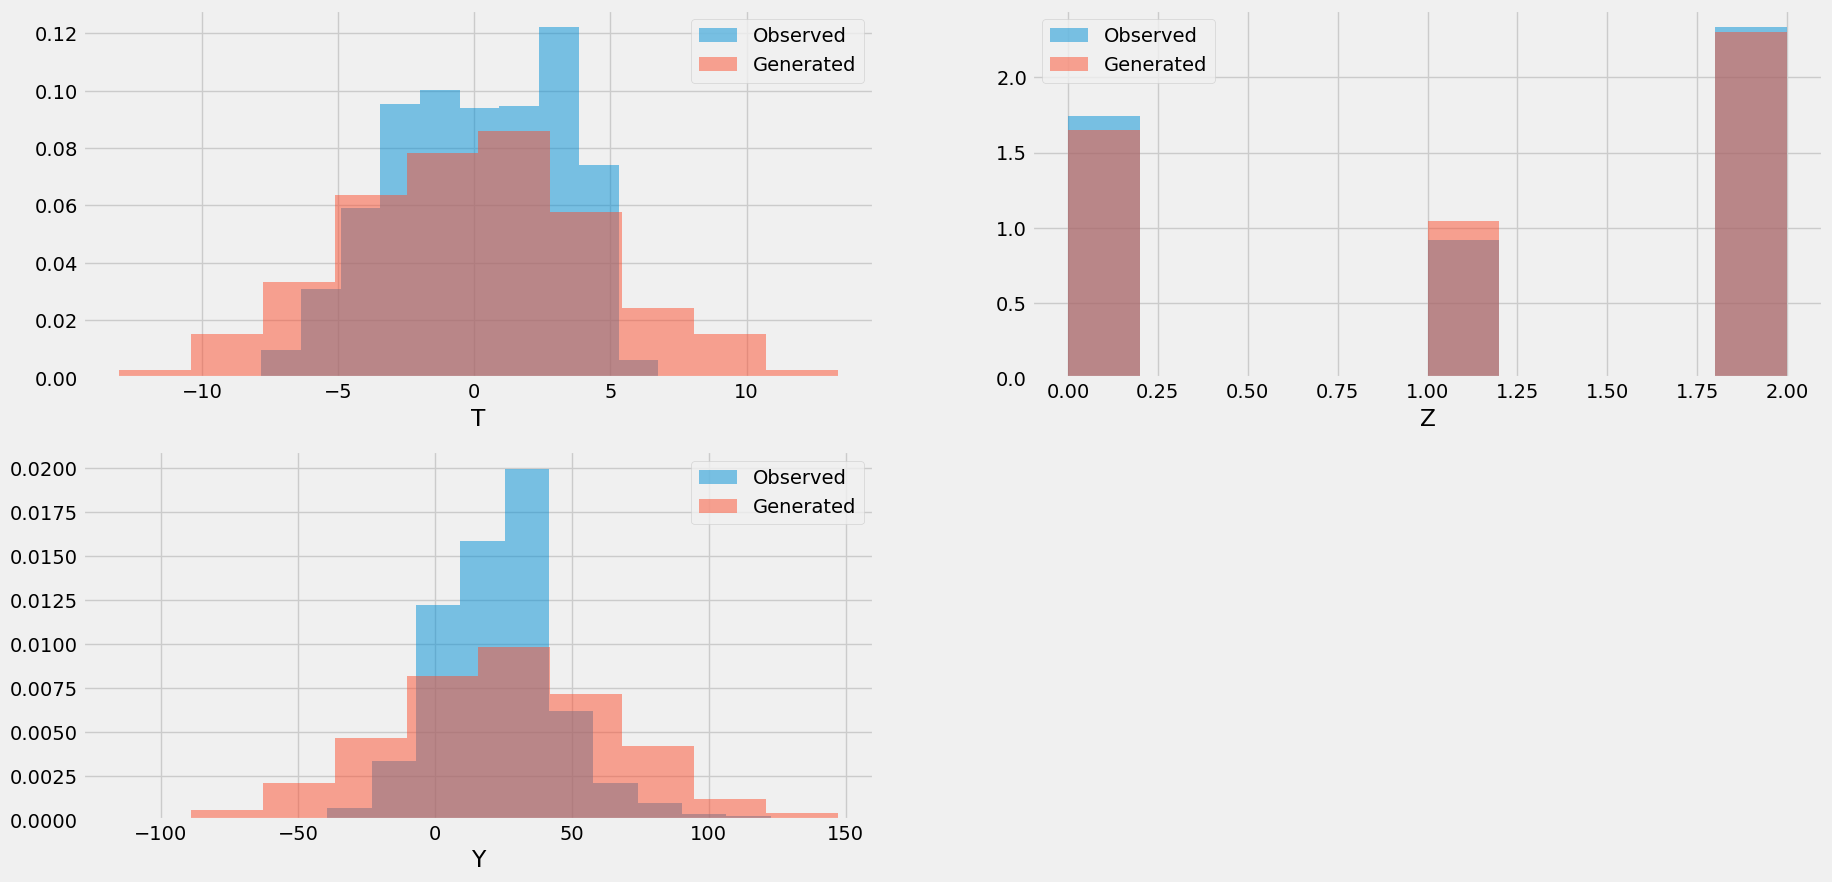

In [35]:
obs_data_df = pd.DataFrame(sample_obs).T
obs_data_df.columns = ['T', 'Z', 'Y']

# Plot histograms
plt.figure(figsize=(20, 10))
for i, v in enumerate(['T', 'Z', 'Y']):
    plt.subplot(2, 2, i+1)
    plt.hist(obs_data_df[v], alpha=.5, label='Observed', density=True)
    plt.hist(generated_data[v], alpha=.5, label='Generated', density=True)
    plt.xlabel(v)
    plt.legend()
    
plt.show()

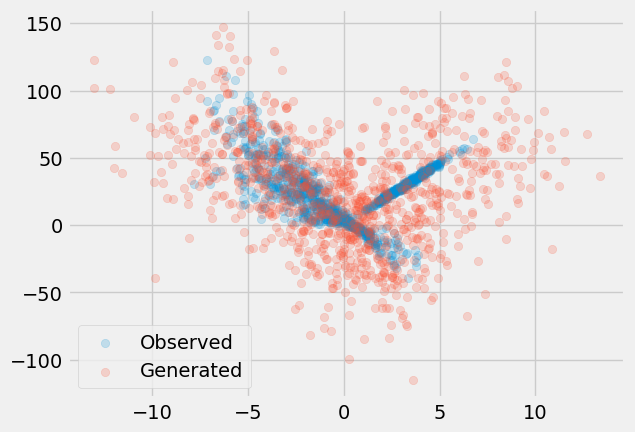

In [36]:
plt.scatter(sample_obs[0], sample_obs[2], alpha=.2, label='Observed')
plt.scatter(generated_data['T'], generated_data['Y'], alpha=.2, label='Generated')
plt.legend()
plt.show()

Test permutations of given graph: 100%|█████████████████████████████████████████████████| 6/6 [00:00<00:00, 624.32it/s]


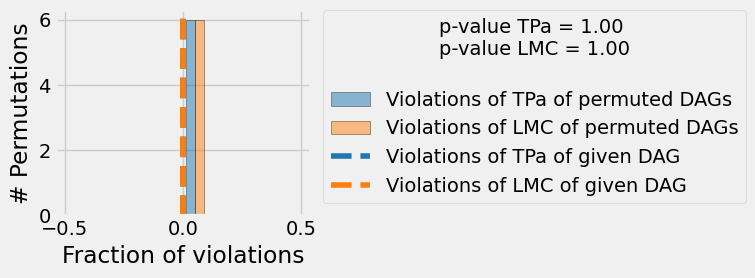

Evaluated and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Generated Distribution ====
The overall average KL divergence between the generated and observed distribution is 0.31005783718015933
The estimated KL divergence indicates an overall very good representation of the data distribution.

==== Evaluation of the Causal Graph Structure ====
+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| Cannot be evaluated!                                                                                  |
+-------------------------------------------------------------------------------------------------------+

==== NOTE ====
Alwa

In [37]:
print(
    gcm.evaluate_causal_model(
        causal_model, 
        data, 
        evaluate_causal_mechanisms=False,
        evaluate_invertibility_assumptions=False)
)